# Credit Card Fraud

Using [this credit card fraud dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud/kernels) develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [1]:
# The basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
creditcard = pd.read_csv('C:\\Users\\User\\Documents\\Python_scripts\\Thinkful\\creditcard.csv')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploring the data

In [167]:
creditcard.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

The datasets contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

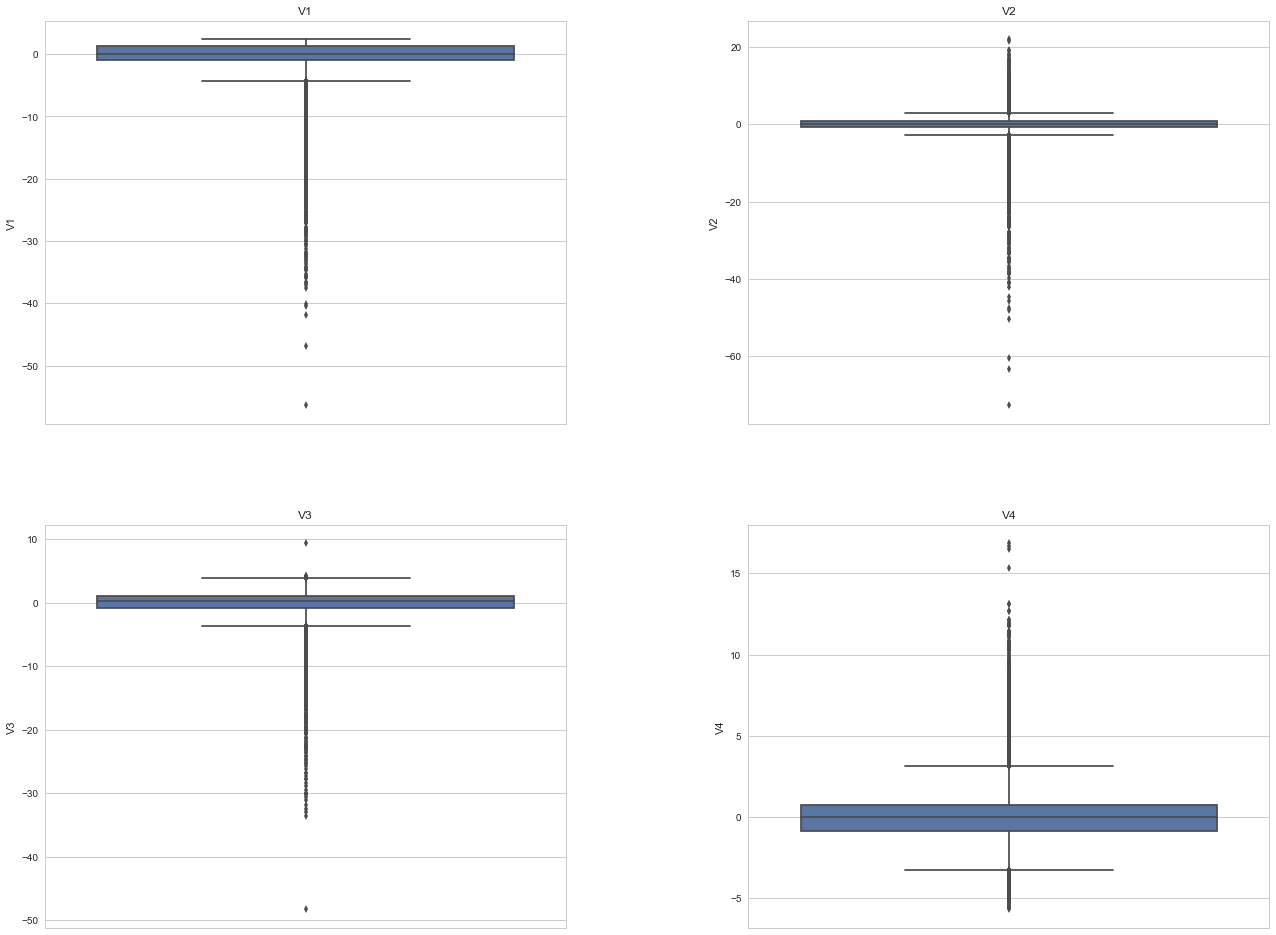

In [23]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,15))
plt.subplot(221)
sns.boxplot(y = 'V1', data=creditcard)
plt.title('V1')
plt.subplot(222)
sns.boxplot(y = 'V2', data=creditcard)
plt.title('V2')
plt.subplot(223)
sns.boxplot(y = 'V3', data=creditcard)
plt.title('V3')
plt.subplot(224)
sns.boxplot(y = 'V4', data=creditcard)
plt.title('V4')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

PCA features (V1 - V28) are already centered and standardized (because the principle components have to be centered and standardized before the transformation occurs).

Amount and Time are the only two components with different means and standard deviations. 

Features are centered, but contain several outliers.

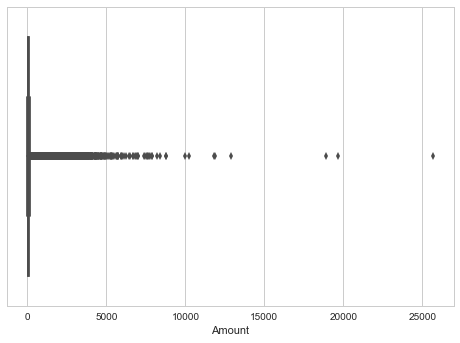

In [60]:
sns.boxplot(creditcard.Amount)

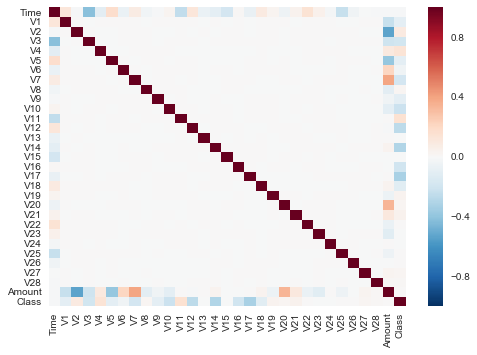

In [37]:
# Checking correlations
corrs = creditcard.corr()
sns.heatmap(corrs)

In [74]:
from sklearn import preprocessing
from sklearn import model_selection

# Scale using RobustScale to account for outliers in Amount
scaler = preprocessing.RobustScaler()
norm = scaler.fit_transform(creditcard.loc[:,['Amount', 'Time']])
norm = pd.DataFrame(norm, columns=['Amount', 'Time'])

# Get data into the right shape, drop Amount, Time, Class
credit = creditcard.loc[:, ~((creditcard.columns).isin(['Amount', 'Time', 'Class']))]

# Add transformed Amount and Time for final features (X) and create outcome (Y)
X = pd.concat([credit, norm], axis=1)
y = creditcard['Class']

# Split on X and y, stratifying on y
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y)

In [75]:
# Making the X_train set balanced w.r.t y

# First join X_train and y_train again
Xwithy = X_train.copy()
Xwithy['y']=y_train

# Then randomly select as 3 times as many features with y=0 as there are where y=1
countoffrauds = Xwithy.loc[Xwithy['y']==1, 'y'].sum()
notfrauds = Xwithy.loc[Xwithy['y']==0, :].sample(countoffrauds*3, replace=False)

# Get a dataset of only y=1
fraud = Xwithy.loc[Xwithy['y']==1,:]

# Join the two datasets
balanced = pd.concat([notfrauds, fraud])

#Split out X and y again
y_balanced = balanced['y']
X_balanced = balanced.drop('y', axis=1)

print(y_balanced.value_counts())
print(len(X_balanced))

0    1107
1     369
Name: y, dtype: int64
1476


## Logistic regression with Ridge


### Standard logistic model

Logistic regression is a good baseline model. The heatmap shows that multicollinearity is low among features and the scatter plots show some (log) linearity.

In [76]:
from sklearn import linear_model

# Running logit with Ridge penalty
logit = linear_model.LogisticRegression()
logit.fit(X_train, y_train)

# Getting predicted y from test
y_hat = logit.predict_proba(X_test)[:,1]

# Assume threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

Class      0   1
row_0           
0      71067  43
1         12  80
Accuracy is:  0.999227549788
Sensitivity is:  0.650406504065


For credit card fraud monitoring I assume that the most important consideration is maximizing correctly predicted fraud (y = 1 and predicted y =1), while minimizing the number of fraudulent transactions which are classified as non-fraudulent (y=1 and predicted y = 0) as this carries high risk. While misclassifying normal transaction as fraudulent also carries some penalty (e.g. resources to investigate possible fraud and possible customer unhappiness if a card is wrongly blocked) it is arguably carries less financial (and reputational) risk than missing fraudulent transactions.

Hence, the model should optimize on sensitivity (TP/(FN+TP)).

In [174]:
y_test.value_counts()

0    71079
1      123
Name: Class, dtype: int64

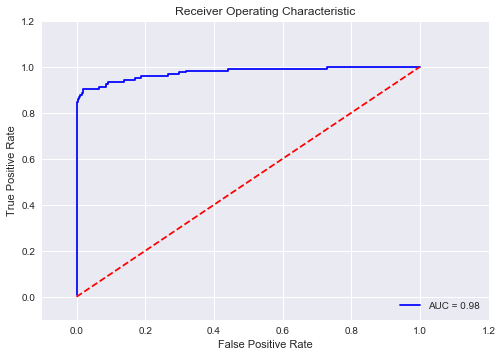

In [61]:
# Optimising threshold - focus is on predicting fraud

from sklearn import metrics

preds = logit.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [77]:
# Assume threshold of .2
threshold = np.where(y_hat>0.2,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)

# Change to df to make life easy
table_pd = pd.DataFrame(cross)

acc = (cross[0][0]+cross[1][1])/len(y_hat)

test_tI_errors = table_pd.iloc[0,1]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
test_tII_errors = table_pd.iloc[1,0]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
sensitive = table_pd.iloc[1,1]/(table_pd.iloc[1,1]+table_pd.iloc[0,1])
print((
    'Test set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set sensitivity: {}').format(acc, test_tI_errors, test_tII_errors, sensitive))

Class      0   1
row_0           
0      71050  26
1         29  97
Test set accuracy: 0.9992275497879273
Percent Type I errors: 0.00036515828207072835
Percent Type II errors: 0.0004072919300019662
Test set sensitivity: 0.7886178861788617


So by setting a low threshold the sensitivity of the model (TP/(FN + TP)) is improved (from 0.63).  However this comes at a cost of nearly tripling the amount of false positives - which can lead to extra work for the fraud detection unit (more cases to assess) and may lead to client unhappiness (e.g. if a credit card is blocked when no fraud is present).

The low threshold is interesting. Given the large inbalance in the dataset (towards Class 0) we are basically interpreting *any* positive probability of fraud (for a particular Xi) as a fraud case.

In [78]:
# Cross validating to make sure the model is not overfitting
score = 'recall'
logit = linear_model.LogisticRegression()
sensitivity_cv = model_selection.cross_val_score(logit, X, y, cv = 8, scoring=score)
print(sensitivity_cv)

# Try StratiefiedKFold
count = 0
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    Xs_train, Xs_test = X.iloc[train_index], X.iloc[test_index]
    ys_train, ys_test = y.iloc[train_index], y.iloc[test_index]
    logit = linear_model.LogisticRegression()
    logit.fit(Xs_train, ys_train)
    y_hat = log.predict_proba(Xs_test)[:,1]
    # Threshold of 0.3
    threshold = np.where(y_hat>0.3,1,0)
    cross = pd.crosstab(threshold, ys_test)
    print(cross)
    acc = (cross[0][0]+cross[1][1])/len(y_hat)
    sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
    count += 1
    print('Accuracy for fold {} is {}'.format(count, acc))
    print('Sensitivity for fold {} is {}'.format(count, sensitive))


[ 0.87096774  0.53225806  0.51612903  0.4516129   0.60655738  0.6557377
  0.54098361  0.47540984]
Class      0   1
row_0           
0      55463   1
1       1400  98
Accuracy for fold 1 is 0.9754046557354026
Sensitivity for fold 1 is 0.98989898989899
Class      0   1
row_0           
0      55420   2
1       1443  97
Accuracy for fold 2 is 0.9746322109476493
Sensitivity for fold 2 is 0.9797979797979798
Class      0   1
row_0           
0      55427   4
1       1436  94
Accuracy for fold 3 is 0.9747195449518091
Sensitivity for fold 3 is 0.9591836734693877
Class      0   1
row_0           
0      55490   4
1       1373  94
Accuracy for fold 4 is 0.9758255648601675
Sensitivity for fold 4 is 0.9591836734693877
Class      0   1
row_0           
0      55379   5
1       1484  93
Accuracy for fold 5 is 0.9738593072453082
Sensitivity for fold 5 is 0.9489795918367347


While this model gives a good baseline, the CV shows that it is overfitting and therefore is not a particularly useful model. However, with a stratified split (keeping ratio of y constant at around 98 in each test sample) the model is highly accurate, but this comes at the cost of substantially (50 times more) increase in false positives. It also shows that some of the poor results in the initial CV may be due to low fraud observations (y=1) in some of the folds. This is worth keeping in mind for the rest of the notebook.


### Logit with balanced dataset

In [79]:
# Running logit with Ridge penalty
logit = linear_model.LogisticRegression()
logit.fit(X_balanced, y_balanced)

# Getting predicted y from test
y_hat = logit.predict_proba(X_test)[:,1]

# Assume threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

# Assume threshold of .2
print("Threshold of 0.2")
threshold = np.where(y_hat>0.2,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

Class      0    1
row_0            
0      70239   10
1        840  113
Accuracy is:  0.988062133086
Sensitivity is:  0.918699186992
Threshold of 0.2
Class      0    1
row_0            
0      68560    8
1       2519  115
Accuracy is:  0.964509423893
Sensitivity is:  0.934959349593


In [80]:
# Own style CV to take account of balanced model
# Apply model to a couple of representative samples (stratify sampling)
# Note the model would've seen some, but not all of the y observations
# Key is to test stability

# 5 folds

for i in range(1,6): 
    Xb_train, Xb_test, yb_train, yb_test = model_selection.train_test_split(X, y, stratify=y)
    y_hat = logit.predict_proba(Xb_test)[:,1]
    # Threshold of 0.5
    threshold = np.where(y_hat>0.5,1,0)
    cross = pd.crosstab(threshold, yb_test)
    print(cross)
    acc = (cross[0][0]+cross[1][1])/len(y_hat)
    sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
    print('Accuracy for fold {} is {}'.format(i, acc))
    print('Sensitivity for fold {} is {}'.format(i, sensitive))

Class      0    1
row_0            
0      70222   13
1        857  110
Accuracy for fold 1 is 0.987781242099941
Sensitivity for fold 1 is 0.8943089430894309
Class      0    1
row_0            
0      70268   10
1        811  113
Accuracy for fold 2 is 0.9884694250161512
Sensitivity for fold 2 is 0.9186991869918699
Class      0    1
row_0            
0      70303   15
1        776  108
Accuracy for fold 3 is 0.9888907614954636
Sensitivity for fold 3 is 0.8780487804878049
Class      0    1
row_0            
0      70234   11
1        845  112
Accuracy for fold 4 is 0.9879778657902868
Sensitivity for fold 4 is 0.9105691056910569
Class      0    1
row_0            
0      70258   14
1        821  109
Accuracy for fold 5 is 0.9882728013258054
Sensitivity for fold 5 is 0.8861788617886179


This model performs relatively well with a 0.5 threshold (greater precision can be achieved but results in substantially higher false positives). Note however, that the cross-validation technique will include some of the trained samples too, and is therefore not a perfect measure of out of sample performance. 


### Logit with smaller feature space


In [67]:

# Running logit with Ridge penalty
logit = linear_model.LogisticRegression()
logit.fit(X_train.loc[:, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
                          'V7', 'V8', 'V9', 'V10', 'Amount']], y_train)

# Getting predicted y from test
y_hat = logit.predict_proba(X_test.loc[:, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 
                          'V7', 'V8', 'V9', 'V10', 'Amount']])[:,1]

# Assume threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

Class      0   1
row_0           
0      71066  65
1         13  58
Accuracy is:  0.998904525154
Sensitivity is:  0.471544715447




### Summary for Logit model

This section used 3 variations of logit model:
1. Standard logit (Ridge penalty): Precision of 0.72, but signs of overfitting
2. Logit with oversampling of y: Precision improved, to around 0.9, but at a cost of a higher FP rate. Relatively stable in cross-validation.
3. Logit with smaller featurespace: Much worse precision



## Random forests

### Standard rf

Class      0   1
row_0           
0      71073  26
1          6  97
Accuracy is:  0.999550574422
Sensitivity is:  0.788617886179


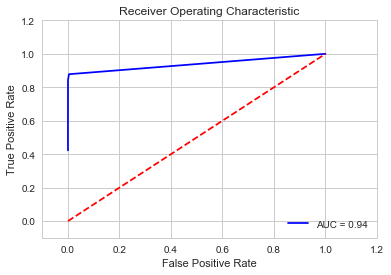

In [179]:
from sklearn import ensemble

# Initialising and fitting the model
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)

# Testing prediction
y_hat = rf.predict_proba(X_test)[:,1]

# Assume threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

preds = rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [180]:
# Assume threshold of .2
threshold = np.where(y_hat>0.2,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)

# Change to df to make life easy
table_pd = pd.DataFrame(cross)

acc = (cross[0][0]+cross[1][1])/len(y_hat)

test_tI_errors = table_pd.iloc[0,1]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
test_tII_errors = table_pd.iloc[1,0]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
sensitive = table_pd.iloc[1,1]/(table_pd.iloc[1,1]+table_pd.iloc[0,1])
print((
    'Test set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set sensitivity: {}').format(acc, test_tI_errors, test_tII_errors, sensitive))

Class      0    1
row_0            
0      71063   20
1         16  103
Test set accuracy: 0.9994943962248252
Percent Type I errors: 0.0002808909862082526
Percent Type II errors: 0.00022471278896660205
Test set sensitivity: 0.8373983739837398


This is a good improvement in precision from the logit model, with the lower Type II errors.

However, random forests can suffer from high variance (if they are not pruned) which makes their results fragile to the specific training data used.

In [181]:
# Cross validating to make sure the model is not overfitting
score = 'recall'
rfc = ensemble.RandomForestClassifier()
recall_cv = model_selection.cross_val_score(rfc, X, y, cv = 5, scoring=score)
print(recall_cv)

[ 0.97979798  0.74747475  0.65306122  0.79591837  0.64285714]


In [83]:
# Try StratiefiedKFold
count = 0
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    Xs_train, Xs_test = X.iloc[train_index], X.iloc[test_index]
    ys_train, ys_test = y.iloc[train_index], y.iloc[test_index]
    rfc = ensemble.RandomForestClassifier()
    rfc.fit(Xs_train, ys_train)
    y_hat = rf.predict_proba(Xs_test)[:,1]
    # Threshold of 0.3
    threshold = np.where(y_hat>0.3,1,0)
    cross = pd.crosstab(threshold, ys_test)
    print(cross)
    acc = (cross[0][0]+cross[1][1])/len(y_hat)
    sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
    count += 1
    print('Accuracy for fold {} is {}'.format(count, acc))
    print('Sensitivity for fold {} is {}'.format(count, sensitive))

Class      0   1
row_0           
0      55429   2
1       1434  97
Accuracy for fold 1 is 0.9747902110178716
Sensitivity for fold 1 is 0.9797979797979798
Class      0   1
row_0           
0      55507   4
1       1356  95
Accuracy for fold 2 is 0.9761244338330817
Sensitivity for fold 2 is 0.9595959595959596
Class      0   1
row_0           
0      55366   4
1       1497  94
Accuracy for fold 3 is 0.9736486367865733
Sensitivity for fold 3 is 0.9591836734693877
Class      0   1
row_0           
0      55409   2
1       1454  96
Accuracy for fold 4 is 0.9744386510068292
Sensitivity for fold 4 is 0.9795918367346939
Class      0   1
row_0           
0      55468   4
1       1395  94
Accuracy for fold 5 is 0.9754393356858201
Sensitivity for fold 5 is 0.9591836734693877


So unfortunately the model is still overfitting according to a standard CV. However, if the model is adjusted to ensure a consistent sample of y, then it performs well.


### RF with class weights

One way to address the imbalance of the data is by using weighted random forest (as suggested [here](https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)).

"Since the RF classifier tends to be biased towards the majority class, we
shall place a heavier penalty on misclassifying the minority class. We assign a weight to each class, with the
minority class given larger weight (i.e., higher misclassification cost). The class weights are incorporated
into the RF algorithm in two places. In the tree induction procedure, class weights are used to weight
the Gini criterion for finding splits. In the terminal nodes of each tree, class weights are again taken into
consideration. The class prediction of each terminal node is determined by “weighted majority vote”; i.e.,
the weighted vote of a class is the weight for that class times the number of cases for that class at the
terminal node. The final class prediction for RF is then determined by aggregatting the weighted vote from
each individual tree, where the weights are average weights in the terminal nodes. Class weights are an
essential tuning parameter to achieve desired performance. The out-of-bag estimate of the accuracy from
RF can be used to select weights."

In [89]:
rfc = ensemble.RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)
y_hat = rfc.predict_proba(X_test)[:,1]

# Assume threshold of .2
threshold = np.where(y_hat>0.2,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)

# Change to df to make life easy
table_pd = pd.DataFrame(cross)

acc = (cross[0][0]+cross[1][1])/len(y_hat)

test_tI_errors = table_pd.iloc[0,1]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
test_tII_errors = table_pd.iloc[1,0]/(table_pd.iloc[0,0]+table_pd.iloc[1,1]+
                                               table_pd.iloc[1,0]+table_pd.iloc[0,1])
sensitive = table_pd.iloc[1,1]/(table_pd.iloc[1,1]+table_pd.iloc[0,1])
print((
    'Test set accuracy: {}\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n'
    'Test set sensitivity: {}').format(acc, test_tI_errors, test_tII_errors, sensitive))

precision_cv = model_selection.cross_val_score(rfc, X, y, cv = 5, scoring=score)
print(precision_cv)

# Try StratiefiedKFold
count = 0
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in skf.split(X, y):
    Xs_train, Xs_test = X.iloc[train_index], X.iloc[test_index]
    ys_train, ys_test = y.iloc[train_index], y.iloc[test_index]
    rfc = ensemble.RandomForestClassifier(class_weight='balanced')
    rfc.fit(Xs_train, ys_train)
    y_hat = rf.predict_proba(Xs_test)[:,1]
    # Threshold of 0.3
    threshold = np.where(y_hat>0.3,1,0)
    cross = pd.crosstab(threshold, ys_test)
    print(cross)
    acc = (cross[0][0]+cross[1][1])/len(y_hat)
    sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
    count += 1
    print('Accuracy for fold {} is {}'.format(count, acc))
    print('Sensitivity for fold {} is {}'.format(count, sensitive))


Class      0    1
row_0            
0      71062   18
1         17  105
Test set accuracy: 0.9995084407741356
Percent Type I errors: 0.0002528018875874273
Percent Type II errors: 0.0002387573382770147
Test set sensitivity: 0.8536585365853658
[ 0.82828283  0.6969697   0.64285714  0.67346939  0.29591837]
Class      0   1
row_0           
0      55374   2
1       1489  97
Accuracy for fold 1 is 0.97382465503318
Sensitivity for fold 1 is 0.9797979797979798
Class      0   1
row_0           
0      55427   2
1       1436  97
Accuracy for fold 2 is 0.9747550998911555
Sensitivity for fold 2 is 0.9797979797979798
Class      0   1
row_0           
0      55476   4
1       1387  94
Accuracy for fold 3 is 0.97557978265831
Sensitivity for fold 3 is 0.9591836734693877
Class      0   1
row_0           
0      55381   5
1       1482  93
Accuracy for fold 4 is 0.9738944189884307
Sensitivity for fold 4 is 0.9489795918367347
Class      0   1
row_0           
0      55521   3
1       1342  95
Accuracy for

### RF with optimized hyperparameters

In [68]:
# Trying to build a more robust random forest

# Gridsearch to find optimal values of some of the hyperparameters in boosting model
# Adjusting n_estimators to build more complex trees
# Not adjusting max_features - auto works best
# Adjusting min_sample_split to prevent overfitting (could also try max_depth or min_sample_leaf)

params = { "n_estimators" : [5,10,50],
         'min_samples_split': [2,10]}

# Initialize the model
rf = ensemble.RandomForestClassifier()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(rf, params)

#Fit on train datase
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
y_pred_probs = grid.predict_proba(X_test)
table_pd = pd.DataFrame(pd.crosstab(y_pred, y_test, margins=True))
print(table_pd)

grid.best_estimator_

Class      0    1    All
row_0                   
0      71072   36  71108
1          7   87     94
All    71079  123  71202


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [69]:
# Cross validating to make sure the model is not overfitting
score = 'recall'
rfc = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
recall_cv = model_selection.cross_val_score(rfc, X, y, cv = 5, scoring=score)
print(recall_cv)

[ 0.98989899  0.7979798   0.67346939  0.78571429  0.68367347]


### RF with balanced sample

In [70]:

# Initialising and fitting the model
rf = ensemble.RandomForestClassifier()
rf.fit(X_balanced, y_balanced)

# Testing prediction
y_hat = rf.predict_proba(X_test)[:,1]

# Assume threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

# Assume threshold of .2
print("Threshold of 0.2")
threshold = np.where(y_hat>0.2,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

Class      0    1
row_0            
0      70587   18
1        492  105
Accuracy is:  0.992837279852
Sensitivity is:  0.853658536585
Threshold of 0.2
Class      0    1
row_0            
0      67463   12
1       3616  111
Accuracy is:  0.949046375102
Sensitivity is:  0.90243902439


In [72]:
# Apply model to a couple of representative samples (stratify sampling)
# Note the model would've seen some, but not all of the y observations
# Key is to test stability

# 5 folds

for i in range(1,10): 
    Xb_train, Xb_test, yb_train, yb_test = model_selection.train_test_split(X, y, stratify=y)
    y_hat = rf.predict_proba(Xb_test)[:,1]
    # Threshold of 0.2
    threshold = np.where(y_hat>0.5,1,0)
    cross = pd.crosstab(threshold, yb_test)
    print(cross)
    acc = (cross[0][0]+cross[1][1])/len(y_hat)
    sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
    print('Accuracy for fold {} is {}'.format(i, acc))
    print('Sensitivity for fold {} is {}'.format(i, sensitive))

Class      0    1
row_0            
0      70587    7
1        492  116
Accuracy for fold 1 is 0.9929917698941041
Sensitivity for fold 1 is 0.943089430894309
Class      0    1
row_0            
0      70609    6
1        470  117
Accuracy for fold 2 is 0.9933147945282436
Sensitivity for fold 2 is 0.9512195121951219
Class      0    1
row_0            
0      70615    6
1        464  117
Accuracy for fold 3 is 0.9933990618241061
Sensitivity for fold 3 is 0.9512195121951219
Class      0    1
row_0            
0      70584   10
1        495  113
Accuracy for fold 4 is 0.9929075025982417
Sensitivity for fold 4 is 0.9186991869918699
Class      0    1
row_0            
0      70595    5
1        484  118
Accuracy for fold 5 is 0.9931322153872082
Sensitivity for fold 5 is 0.959349593495935
Class      0    1
row_0            
0      70600    6
1        479  117
Accuracy for fold 6 is 0.9931883935844499
Sensitivity for fold 6 is 0.9512195121951219
Class      0    1
row_0            
0      70624

### Summary for random forest classifier

4 models were used
1. Standard random forest classifier: 0.83 sensitivity, but still a lot of variability in CV (suggesting overfitting)
2. Random forest with optimized hyperparameters: Not significant improvement given additional complexity
3. Random forest with weighted class: Performs better than standard rf (sensitivity = 0.85) with no cost in FP
4. Random forest with oversampling: High sensitivity 0.9, but high cost in false positives (30 times of standard rf)

## Gradient boosting

In [31]:
from sklearn import ensemble

# Gradient boost with default hyperparameters
gbc = ensemble.GradientBoostingClassifier(n_estimators=200)
gbc.fit(X_train, y_train)

# Testing prediction
y_hat = gbc.predict_proba(X_test)[:,1]

# Assume threshold of .5
threshold = np.where(y_hat>0.5,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)



Class      0   1
row_0           
0      71069  37
1         10  86
Accuracy is:  0.999339906182
Sensitivity is:  0.69918699187


In [18]:
# Assume threshold of .1
threshold = np.where(y_hat>0.1,1,0)
cross = pd.crosstab(threshold, y_test)
print(cross)
acc = (cross[0][0]+cross[1][1])/len(y_hat)
sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
print('Accuracy is: ', acc)
print('Sensitivity is: ', sensitive)

Class      0   1
row_0           
0      71043  39
1         36  84
Accuracy is:  0.998946658802
Sensitivity is:  0.682926829268


### Gridsearch to optimize hyperparameters

In [90]:
# Gridsearch to find optimal values of some of the hyperparameters in boosting model
params = {'n_estimators': [10, 100, 200],
          'max_depth': [2, 4]}
# Initialize the model
gbc = ensemble.GradientBoostingClassifier()
grid = model_selection.GridSearchCV(gbc, params)

#Fit on train datase
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
table_pd = pd.DataFrame(pd.crosstab(y_test, y_pred, margins=True))
print(table_pd)

grid.best_estimator_

col_0      0    1    All
Class                   
0      71056   23  71079
1         20  103    123
All    71076  126  71202


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

### Summary for Gradient boost

Here two gradient boost models were calculated:
1. Standard gradient boost: lower precision than logit and rf 
2. Optimized gradient boost through GridSearch: High cost in terms of calculation, and gains are comparable to logit and random forest models (but with lower false positives)

## Conclusion

The final model depends on the how the tradeoff between high precision and high false positives is resolved. The random forest outperformed the logistic regressions, and was substantially faster to implement than the gradient boost models. The random forest model based on oversampling fraud cases provides the highest precision (but also has a high false positive rate), while the random forest model with weighted classes provides the highest precision while keeping false positives relatively low.